## PYPSA-USA Technical Appendix

PYPSA-USA Repository: https://github.com/PyPSA/pypsa-usa/tree/master


### PYPSA-USA Data Sources 

|Input Data | Description | Source |
| --- | --- | --- |
|BA_Shapes_new| Shape file used as inputs to produce geojson images. The shape file inputs return country and state boundary geojson .png files. | PYPSA-USA Repository | 
| BOEM_CA_OSW_GIS| Shape file used as inputs to produce geojson images. The shape file inputs are specific to California and return onshore and offshore wind geojson .png files.| PYPSA-USA Repository|
|NERC_Regions| Shape file used as input to produce geojson images for each NERC region and subregion.| PYPSA-USA Repository|
|carbonconstraints | Data files that contain information on carbon capture rates for different types of coal and gas plants. Additionally, data is provided on carbon cap, carbon tax, methane leakage, and penalty rates.| ReEDS Constraints - PYPSA-USA Repository|
|national_generation| General mandated technology list accompanied with a general mandated technology trajectory forecast up to 2040.|ReEDS Constraints - PYPSA-USA Repository|
|reserves| Estimates on static and ramping levels at the balancing authority level (nercr) up to 2050.|ReEDS Constraints - PYPSA-USA Repository|
|state_policies| Variety of state level data for energy mandates, offshore requirements and banned technologies.| ReEDS Constraints - PYPSA-USA Repository|
|Transmissions| https://github.com/PyPSA/pypsa-usa/blob/master/workflow/repo_data/ReEDS_Constraints/transmission/README.md | TEPPC:  https://www.wecc.org/Administrative/TEPPC_TransCapCostCalculator_E3_2019_Update.xlsx, SCE: http://www.caiso.com/Documents/SCE2019DraftPerUnitCostGuide.xlsx|
|transmission_capacity_init_AC_NARIS2024|  Initial AC transmission capacities between 134 US ReEDS zones. Calculated using the code available at https://github.nrel.gov/pbrown/TSC and nodal network data from NREL. The method is described by Brown, P.R. et al 2023, "A general method for estimating zonal transmission interface limits from nodal network data", in prep.| https://www.nrel.gov/docs/fy21osti/79224.pdf.|
|
|membership| Data file containing NERC memberships at the transmission group level.| ReEDS Constraints - PYPSA-USA Repository|
|Reeds_Shapes| Shape file used as an input to produce geojson images for Reeds regions.| PYPSA-USA Repository|
|Locational_Mulipliers|-	Data files that contain project cost estimates for various energy requirements at Reeds regional multiplier locations.| PYPSA-USA Repository|
|Plants| Data files for ADS plant locations, EIA 860 and ADS merged plants, other plants that have merged, fuels costs for 2022, and WECC fuel regions.| PYPSA-USA Repository|
|Retrieve_casio_data| Historical daily natural gas fuel prices are retrieved from CAISO's Open Access Same-time Information System (OASIS). Data is collected on a daily basis for each Balancing Area and Fuel Region that had joined the Western Energy Imbalance Market (WEIM) during the time period designated in the configuration.| http://oasis.caiso.com/mrioasis/logon.do|
|Retrieve_cost_data_eur| Pulls cost data from PYPSA-EU (Source is unclear at the moment)| |
|Retrieve_cost_data_usa| Retrieves cost data for USA. The script starts by pulling NREL ATB power generation data for a specified year (atb_year) then NREL ATB transportation data is collected. |https://oedi-datalake.s3.amazonaws.com/ATB/electricity/parquet/{atb_year}/ATBe.parquet, https://atb-archive.nrel.gov/transportation/2020/files/2020_ATB_Data_VehFuels_Download.xlsx|
|Retrieve_databundles| Pulls NREL EFS load profile zip files. The load profiles represent projected end-use electricity demand for various scenarios of electrification (Reference, Medium, High) and technology advancement (Slow, Moderate, Rapid), developed using the EnergyPATHWAYS (EP) model, as described in Mai et al. (2018). The EP load profiles were further calibrated for use in the ReEDS capacity expansion model (detailed in forthcoming EFS analyses), thus numerical values in this data set differ slightly from those reported in Mai et al. (2018). Load profiles are provided for a subset of years (2018, 2020, 2024, 2030, 2040, 2050) and are aggregated to the state, sector, and select subsector level.| https://data.nrel.gov/submissions/126|
|Retrieve_eulp| Module to download end use load profiles (eulp) for comstock and restock data. Data is downloaded at the state level, multisector 15 minute load profiles for a year which is fixed on 2018 Amy weather data.| https://data.openei.org/submissions/4520|
|Retrieve_forcast_data| Download forecast data from external sources (CEC, WECC). Files contain hourly forecast results developed as part of the California Energy Commission's 2022 Integrated Energy Policy Report Update.| https://efiling.energy.ca.gov/GetDocument.aspx?tn=248357, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248355, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248353, https://www.wecc.org/Reliability/WECC%202030%20ADS%20PCM%202020-12-16%20(V1.5)%20Public%20Data.zip, https://www.wecc.org/Reliability/2032%20ADS%20PCM%20V2.3.2%20Public%20Data.zip|
|Retrieve_gridemissions_data| Historical electrical generation, demand, interchange, and emissions data are retrieved from the GridEmissions. Data is downloaded at hourly temporal resolution and at a spatial resolution of balancing authority region.|https://gridemissions.jdechalendar.su.domains/#/code.| 


In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import plotly.express as px
import pypsa
import gdown
import os
import sys
import netCDF4 as nc
import scipy
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from matplotlib.lines import Line2D
from pypsa.statistics import StatisticsAccessor, get_bus_and_carrier

In [2]:
# Ensure that the pypsa-usa_technical_appendix.ipynb file is saved within the "workflow" folder of the PYPSA-USA repository.
current_dir = os.path.dirname(os.path.abspath('pypsa-usa_technical_appendix.ipynb'))

# Define path to scripts subfolder within the PYPSA-USA repository
subfolder_path = os.path.join(current_dir, 'scripts')
sys.path.append(subfolder_path)

In [340]:
# Import network
network = pypsa.Network()

# UPDATE to user specific file path for desried network
file_path = "C:/Users/alexa/Policy_Integrity/elec_s_20_ec_lv1.0_Ep_E.nc" 

# Import network from file
network.import_from_netcdf(path=file_path)

INFO:pypsa.io:Imported network elec_s_20_ec_lv1.0_Ep_E.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [355]:
# Import data for USA plot
buses = network.buses
carriers = network.carriers
generators = network.generators
storage_units = network.storage_units
lines = network.lines
links = network.links

# Create a series for the size of buses in the network
bus_sizes = generators.groupby("bus").p_nom_opt.sum()
line_values = lines.s_nom_opt
link_values = links.p_nom_opt

In [6]:
# Generate geopandas state boarders for capacity and demand maps.
STATES_TO_REMOVE = [
    "Hawaii",
    "Alaska",
    "Commonwealth of the Northern Mariana Islands",
    "United States Virgin Islands",
    "Guam",
    "Puerto Rico",
    "American Samoa",
]

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
reader = shpreader.Reader(shpfilename)
gdf_states = reader.records()
data = []
for r in gdf_states:
    attr = r.attributes
    if (attr["iso_a2"] in ["US"]) and (attr["name"] not in STATES_TO_REMOVE):
        data.append(
            [
                attr["name"],
                attr["iso_a2"],
                attr["latitude"],
                attr["longitude"],
                r.geometry,
            ]
        )
gdf_states = gpd.GeoDataFrame(
    data, columns=["name", "country", "x", "y", "geometry"]
).set_crs(4326)

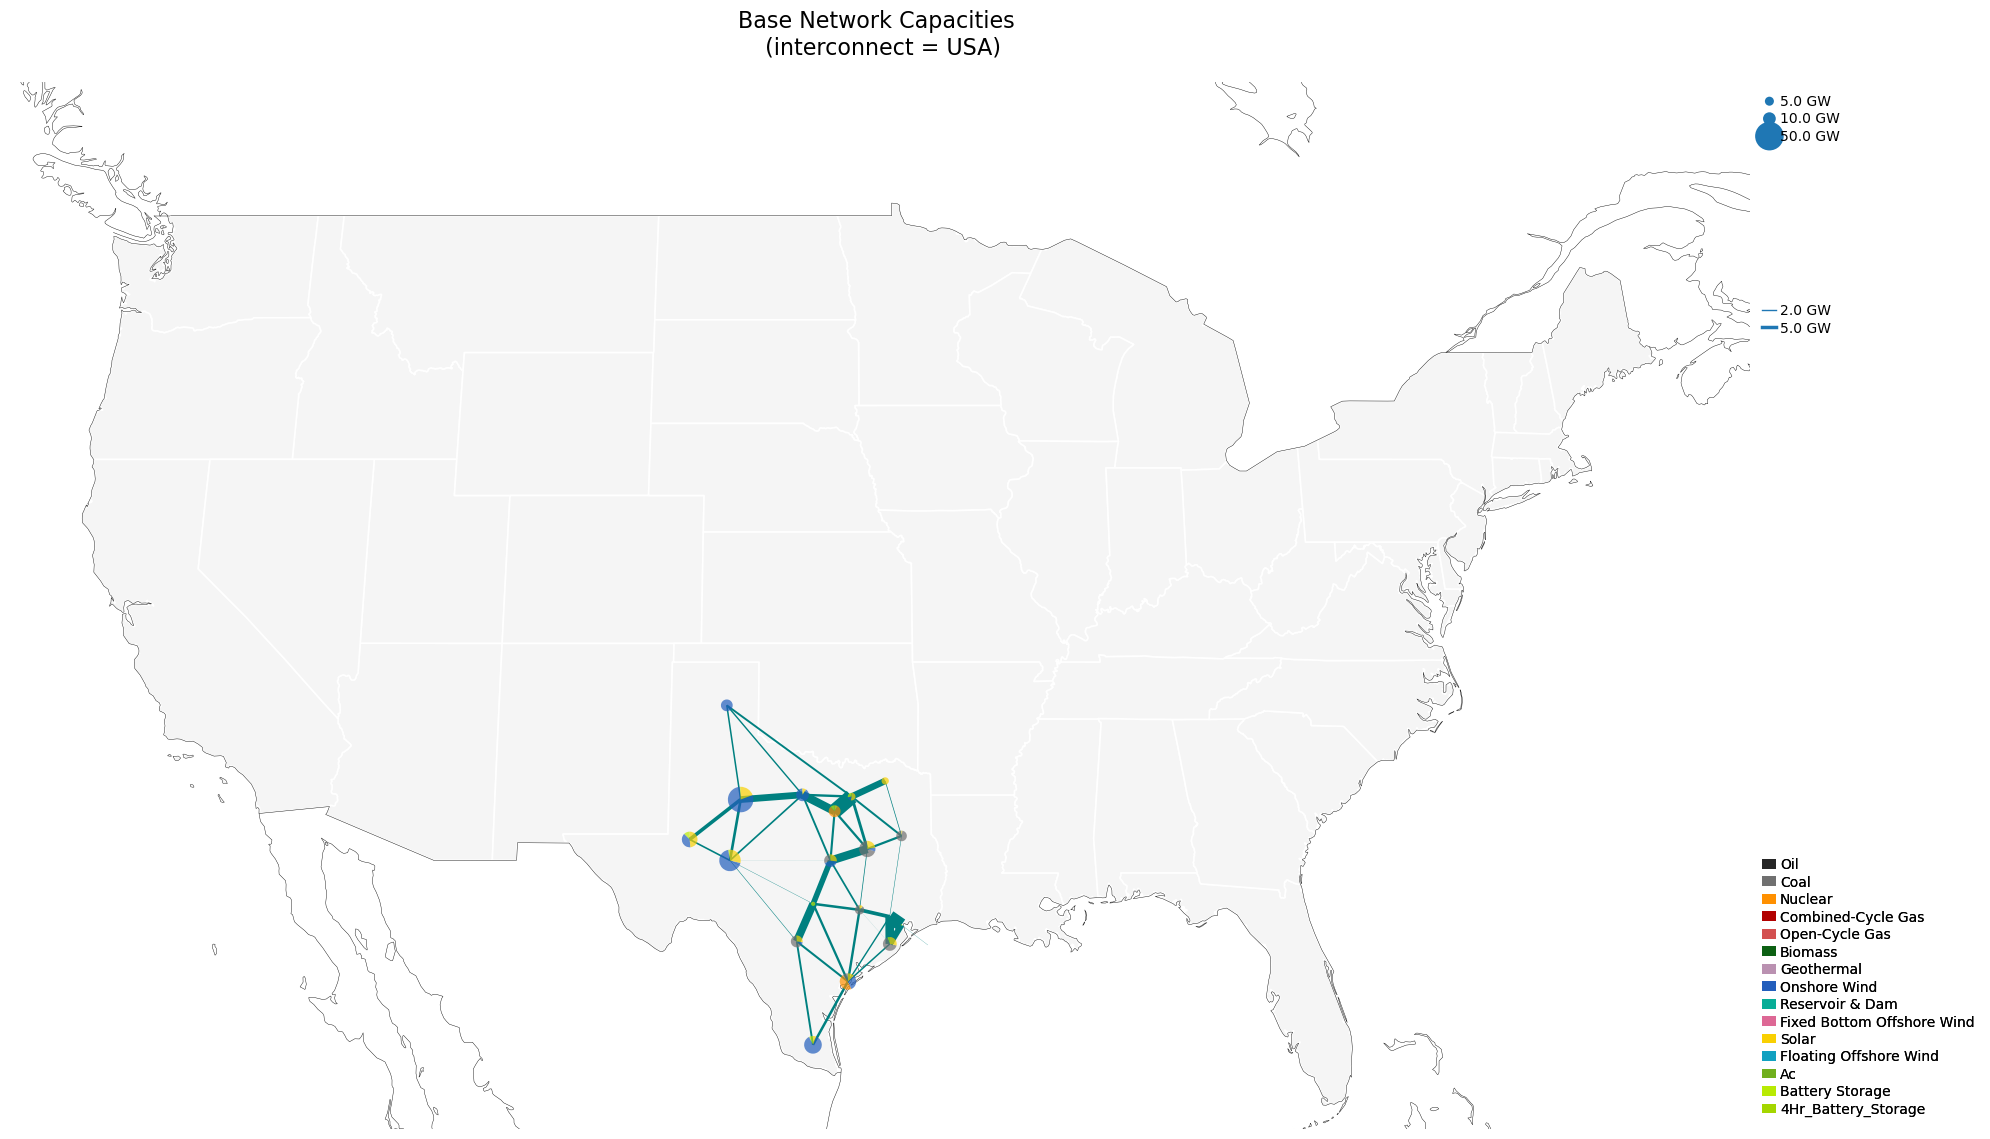

In [342]:
# Import capacity plot function from pypsa-usa scripts.
from plot_network_maps import plot_base_capacity_map, get_capacity_base

# Prevent legends from overlapping
plt.rcParams["legend.labelspacing"] = .25
plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handletextpad"] = .25

# Plot capacity map
plot_base_capacity_map(
    n=network,
    regions=gdf_states, 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png", # chan ge to users file path
    interconnect="USA",
)


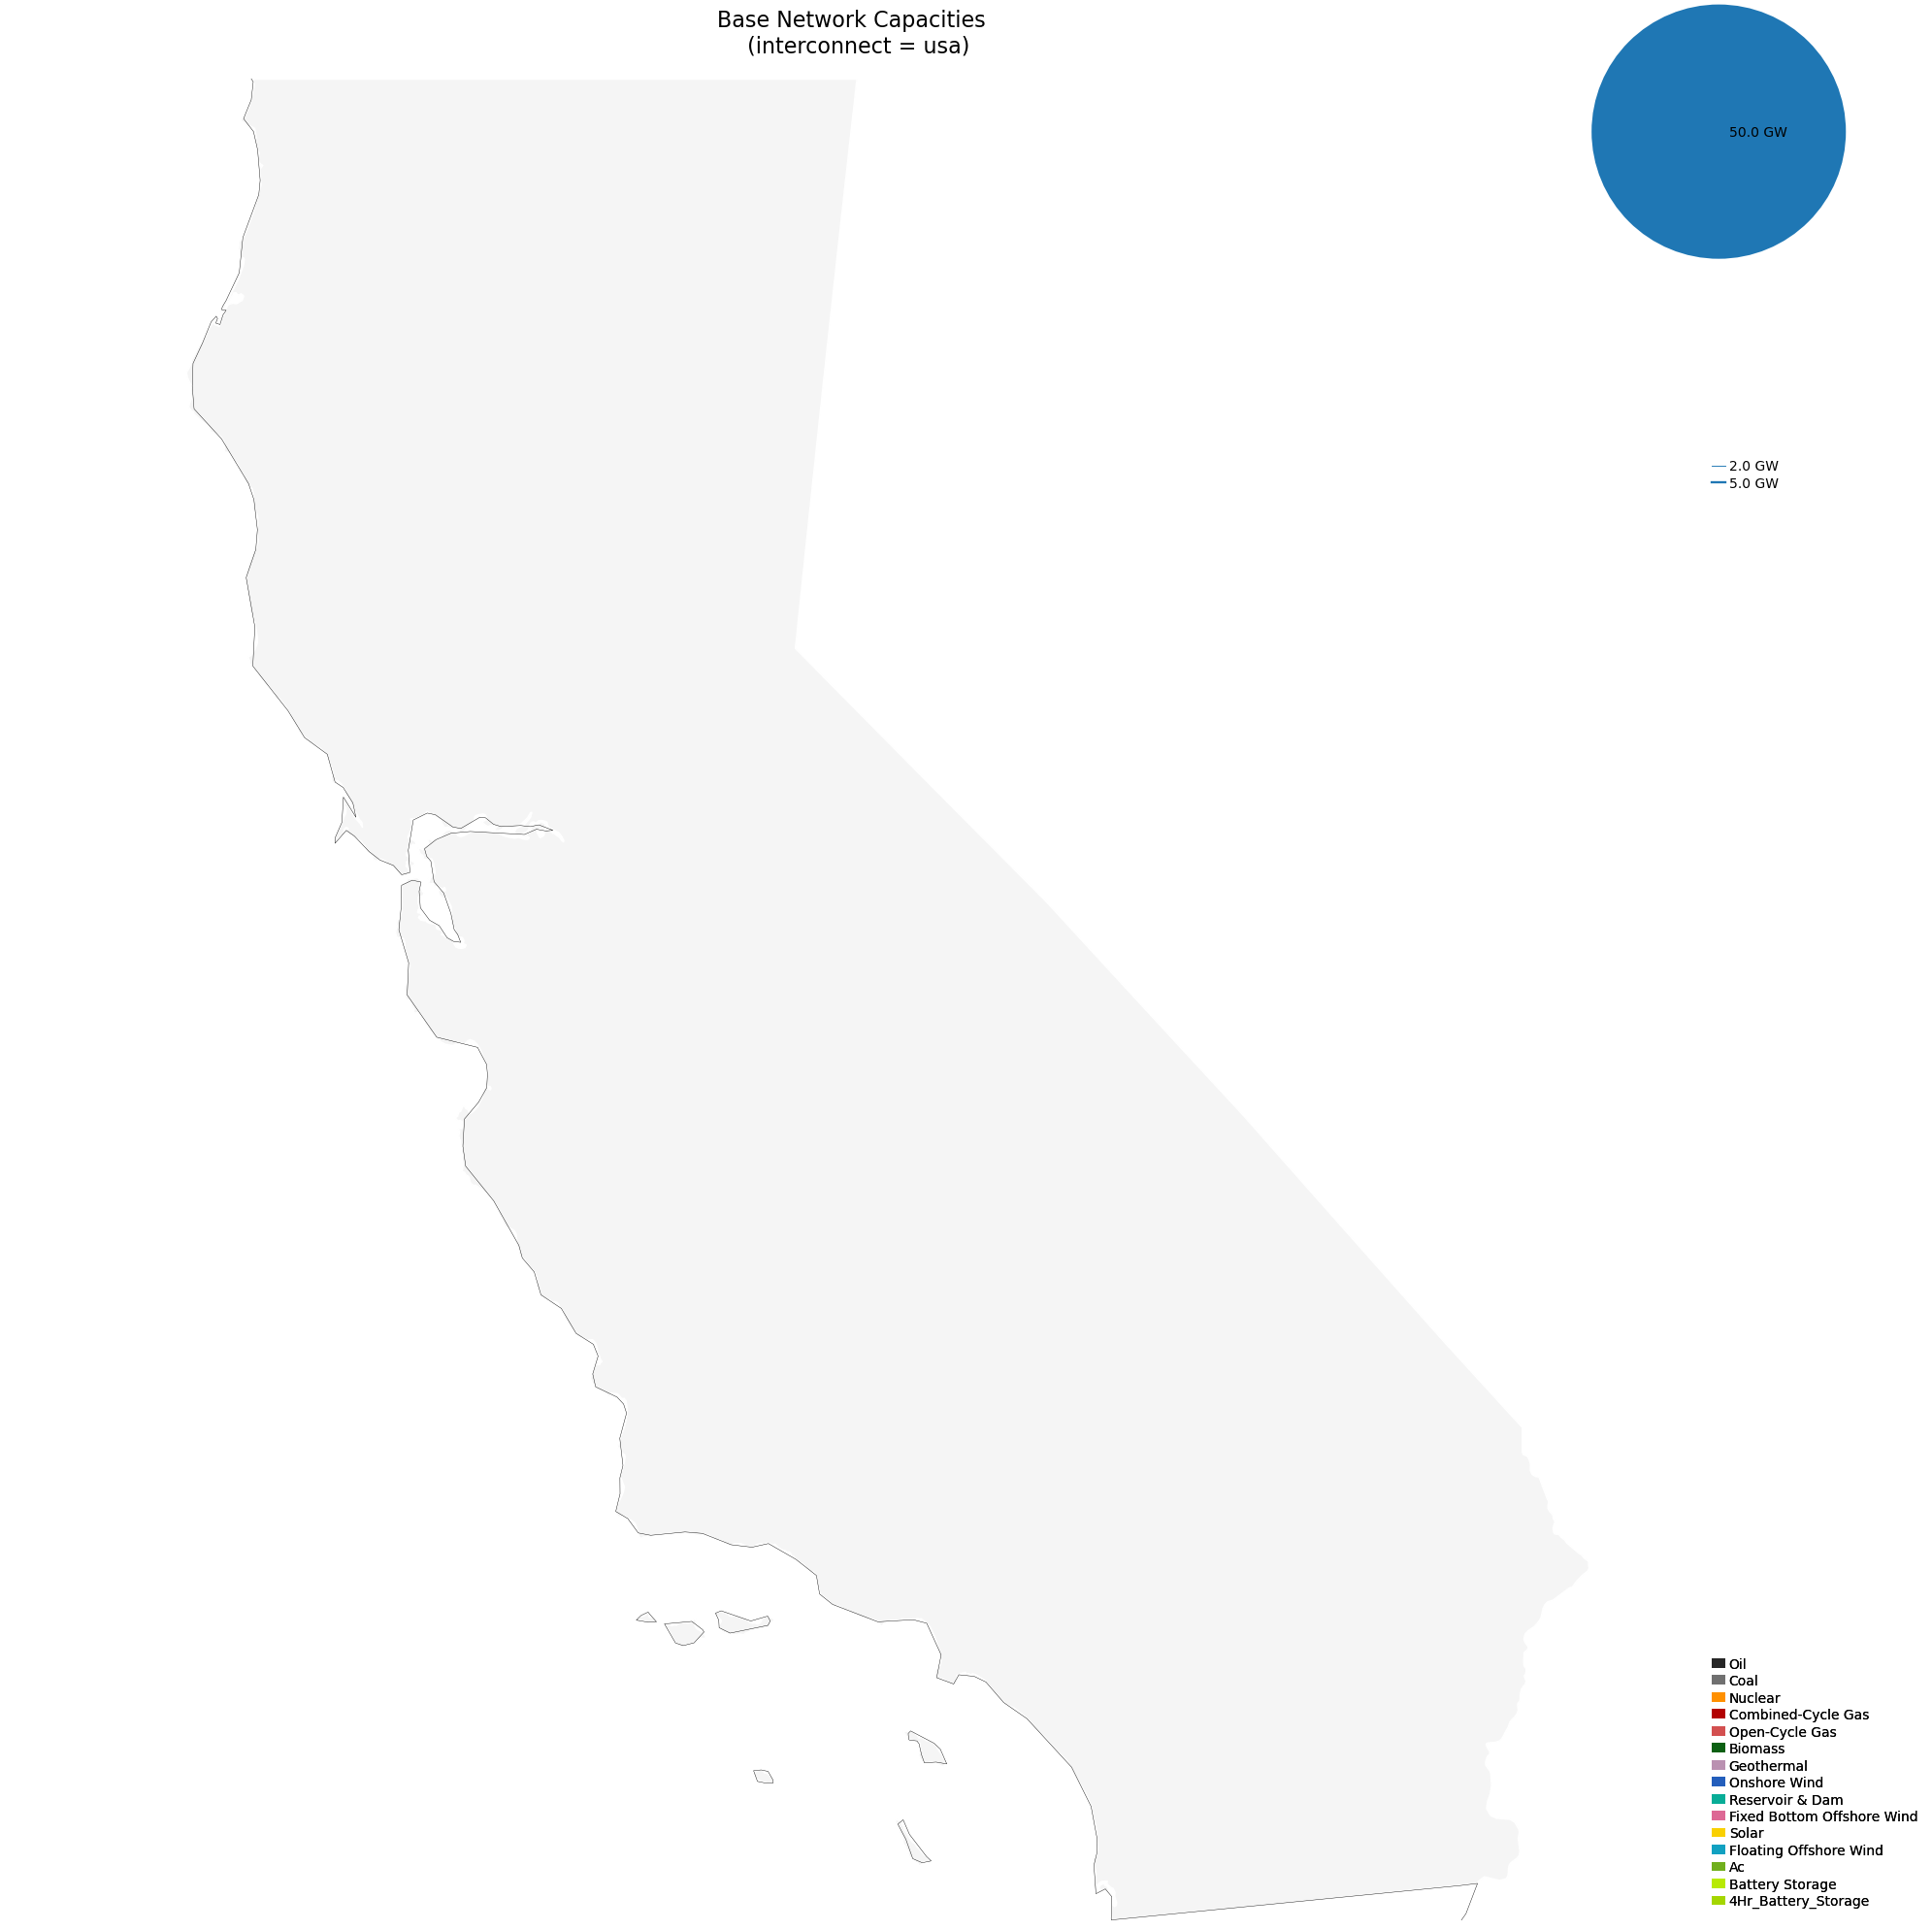

In [343]:
# Example of zooming in on particular state (California). To update, chanage "name == 'STATE'" to desired location. 
plot_base_capacity_map(                                         
    n=network,
    regions=gdf_states.query("name == 'California'"), 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png",
    interconnect="usa",
)

## Summary of Input Data

### Energy Supply Statistics 

In [9]:
# primary energy (i.e. before conversion with losses by generators)
def get_primary_energy_use(n: pypsa.Network) -> pd.DataFrame:
    """
    Gets timeseries primary energy use by bus and carrier.
    """

    link_energy_use = (
        StatisticsAccessor(n)
        .withdrawal(
            comps=["Link", "Store", "StorageUnit"],
            aggregate_time=False,
            groupby=get_bus_and_carrier,
        )
        .droplevel("component")
    )

    gen_dispatch = (
        StatisticsAccessor(n)
        .supply(
            aggregate_time=False,
            comps=["Generator"],
            groupby=pypsa.statistics.get_name_bus_and_carrier,
        )
        .droplevel("component")
    )
    gen_eff = n.get_switchable_as_dense("Generator", "efficiency")

    gen_energy_use = gen_dispatch.T.mul(1 / gen_eff, axis=0, level="name").T.droplevel(
        "name",
    )

    return (
        pd.concat([gen_energy_use, link_energy_use])
        .groupby(["bus", "carrier"])
        .sum()
    )

energy_use = get_primary_energy_use(network)

# Add zonal features to energy use dataframe 
def add_zonal_features(energy_use: pd.DataFrame, buses: pd.DataFrame):
    """
    Returns energy_use dataframe with additional zonal features from buses dataframe.
    """
    buses_select = (buses[["reeds_zone", "reeds_ba", "interconnect", "reeds_state"]]
                    .reset_index()
                    .rename(columns={"Bus": "bus"}))

    energy_use_zonal = energy_use.reset_index()

    energy_use_zonal.columns = energy_use_zonal.columns.droplevel(1)

    energy_use_zonal = (energy_use_zonal.merge(buses_select, on="bus")
                                        .set_index(["bus", "carrier", "reeds_zone", 
                                        "reeds_ba", "interconnect", "reeds_state"]))

    energy_use.columns = [timestamp[1] for timestamp in energy_use.columns]
    energy_use.columns = pd.to_datetime(energy_use.columns)
    energy_use_zonal.columns = energy_use.columns

    return energy_use_zonal

energy_use_zonal = add_zonal_features(energy_use, buses)

# Average monthly energy_use_zonal
energy_use_zonal_monthly = energy_use_zonal.resample("M", axis=1).mean()
energy_use_zonal_monthly.head()

C:\Users\alexa\AppData\Local\Temp\ipykernel_37272\3336481419.py:66: FutureWarning:

DataFrame.resample with axis=1 is deprecated. Do `frame.T.resample(...)` without axis instead.

C:\Users\alexa\AppData\Local\Temp\ipykernel_37272\3336481419.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



2019-01-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.897582   
        Load shedding   p100       PJM      Eastern      VA             0.000042   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.006802   
        Reservoir & Dam p100       PJM      Eastern      VA             0.423044   

                                                                      2019-02-28  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.896903   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.007239   
        Reservoir & Dam p100       PJM      Eastern      VA             1.134691   

                                                                      2019-03-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.896673   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.006954   
        Reservoir & Dam p100       PJM      Eastern      VA             1.116785   

                                                                      2019-04-30  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.895599   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.007512   
        Reservoir & Dam p100       PJM      Eastern      VA             0.994399   

                                                                      2019-05-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.895668   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.008180   
        Reservoir & Dam p100       PJM      Eastern      VA             1.122879   

                                                                      2019-06-30  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.895273   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.010108   
        Reservoir & Dam p100       PJM      Eastern      VA             1.046631   

                                                                      2019-07-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.896378   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.081726   
        Reservoir & Dam p100    

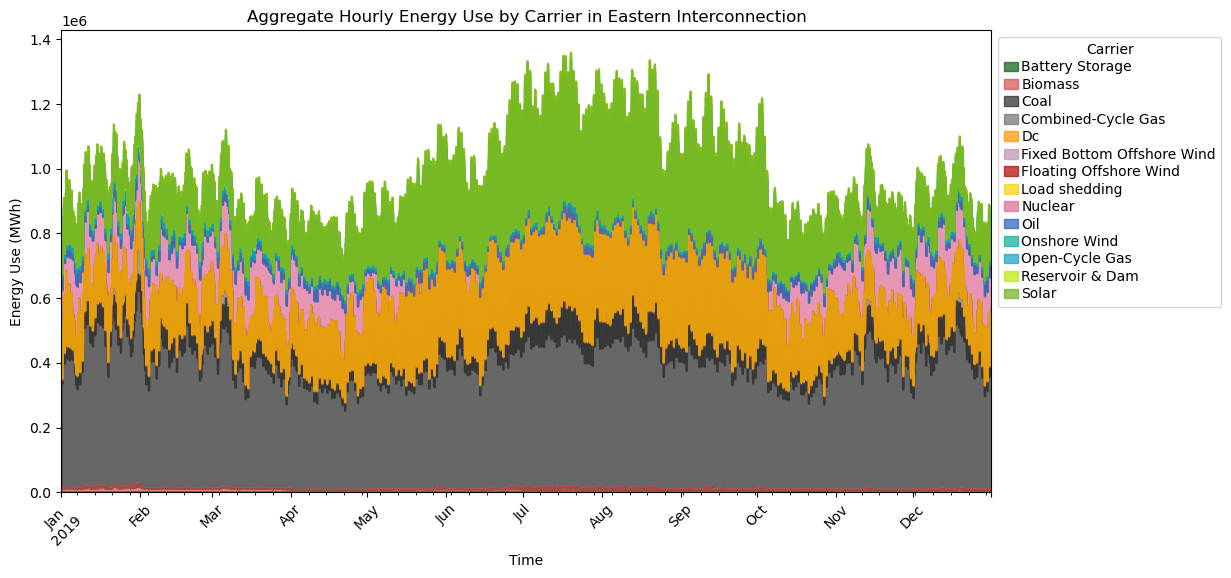

In [10]:
# create dictionary mapping carriers.nice_name and carriers.color
carrier_colors = (carriers[["nice_name", "color"]]
.set_index("nice_name")
.to_dict()["color"])

def plot_energy_use_by_carrier(energy_use_zonal: pd.DataFrame, interconnect: str):
    """
    Plots energy use by carrier for a given interconnect.
    """
    # Select data for interconnect
    data = energy_use_zonal.loc(axis=0)[:, :, :, :, interconnect].groupby(["carrier"]).sum().T

    # Plot data. Use get_color_palette() to get a list of colors for the plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"Aggregate Hourly Energy Use by Carrier in {interconnect} Interconnection")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier for the specified interconnection
plot_energy_use_by_carrier(energy_use_zonal, "Eastern")


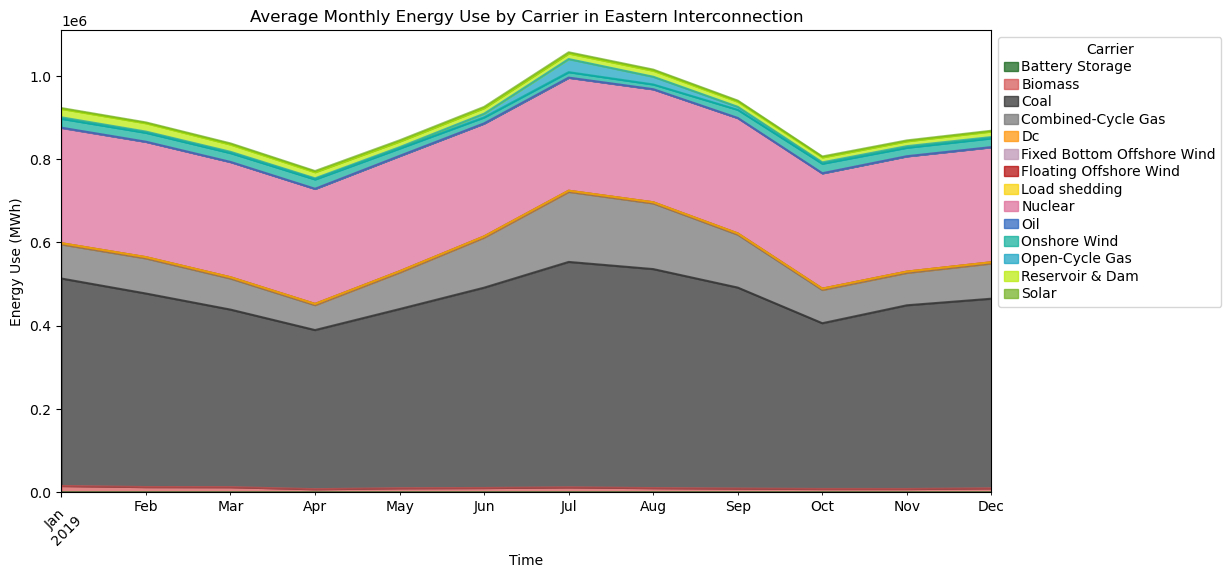

In [11]:
def plot_energy_use_by_carrier_monthly(energy_use_zonal_monthly: pd.DataFrame, interconnect: str):
    """
    Plots energy use by carrier for a given interconnect.
    """
    # Select data for interconnect
    data = energy_use_zonal_monthly.loc(axis=0)[:, :, :, :, interconnect].groupby(["carrier"]).sum().T

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"Average Monthly Energy Use by Carrier in {interconnect} Interconnection")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier aggregated by month for specified interconnection
plot_energy_use_by_carrier_monthly(energy_use_zonal_monthly, "Eastern")

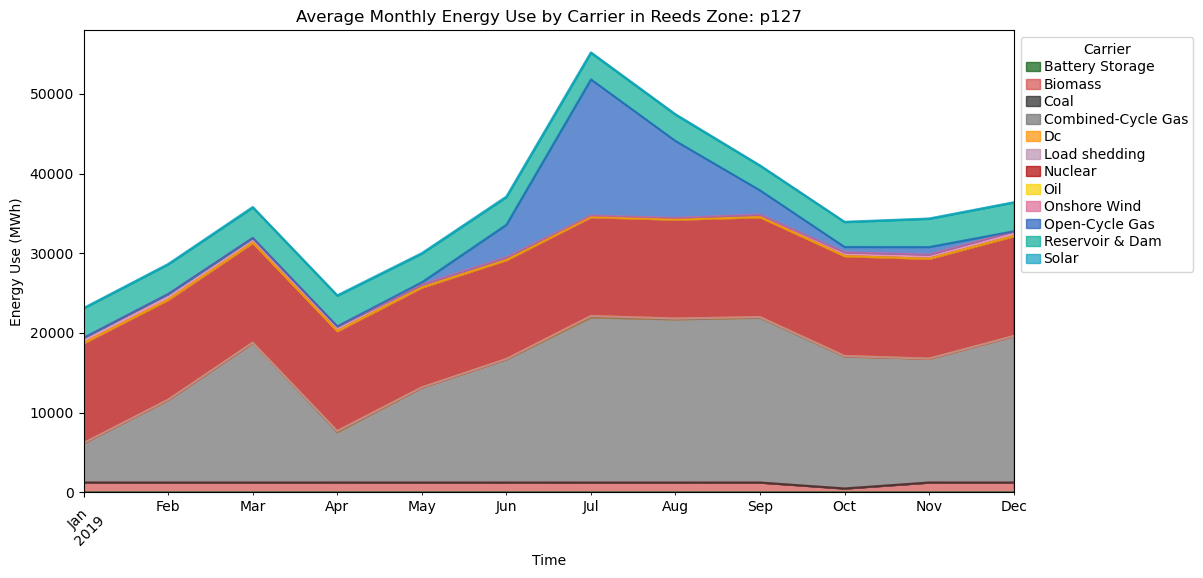

In [13]:
def plot_energy_use_by_carrier_zone(energy_use_zonal: pd.DataFrame, reeds_zone: str):
    """
    Plots energy use by carrier for a given reeds zone.
    """
    # Select data for reeds zone
    data = energy_use_zonal.loc(axis=0)[:, :, reeds_zone, :, :].groupby(["carrier"]).sum().T

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"Average Monthly Energy Use by Carrier in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier and reeds zone
plot_energy_use_by_carrier_zone(energy_use_zonal_monthly, "p127") #p127 is an NY Reeds Zone


### Energy Demand Statistics

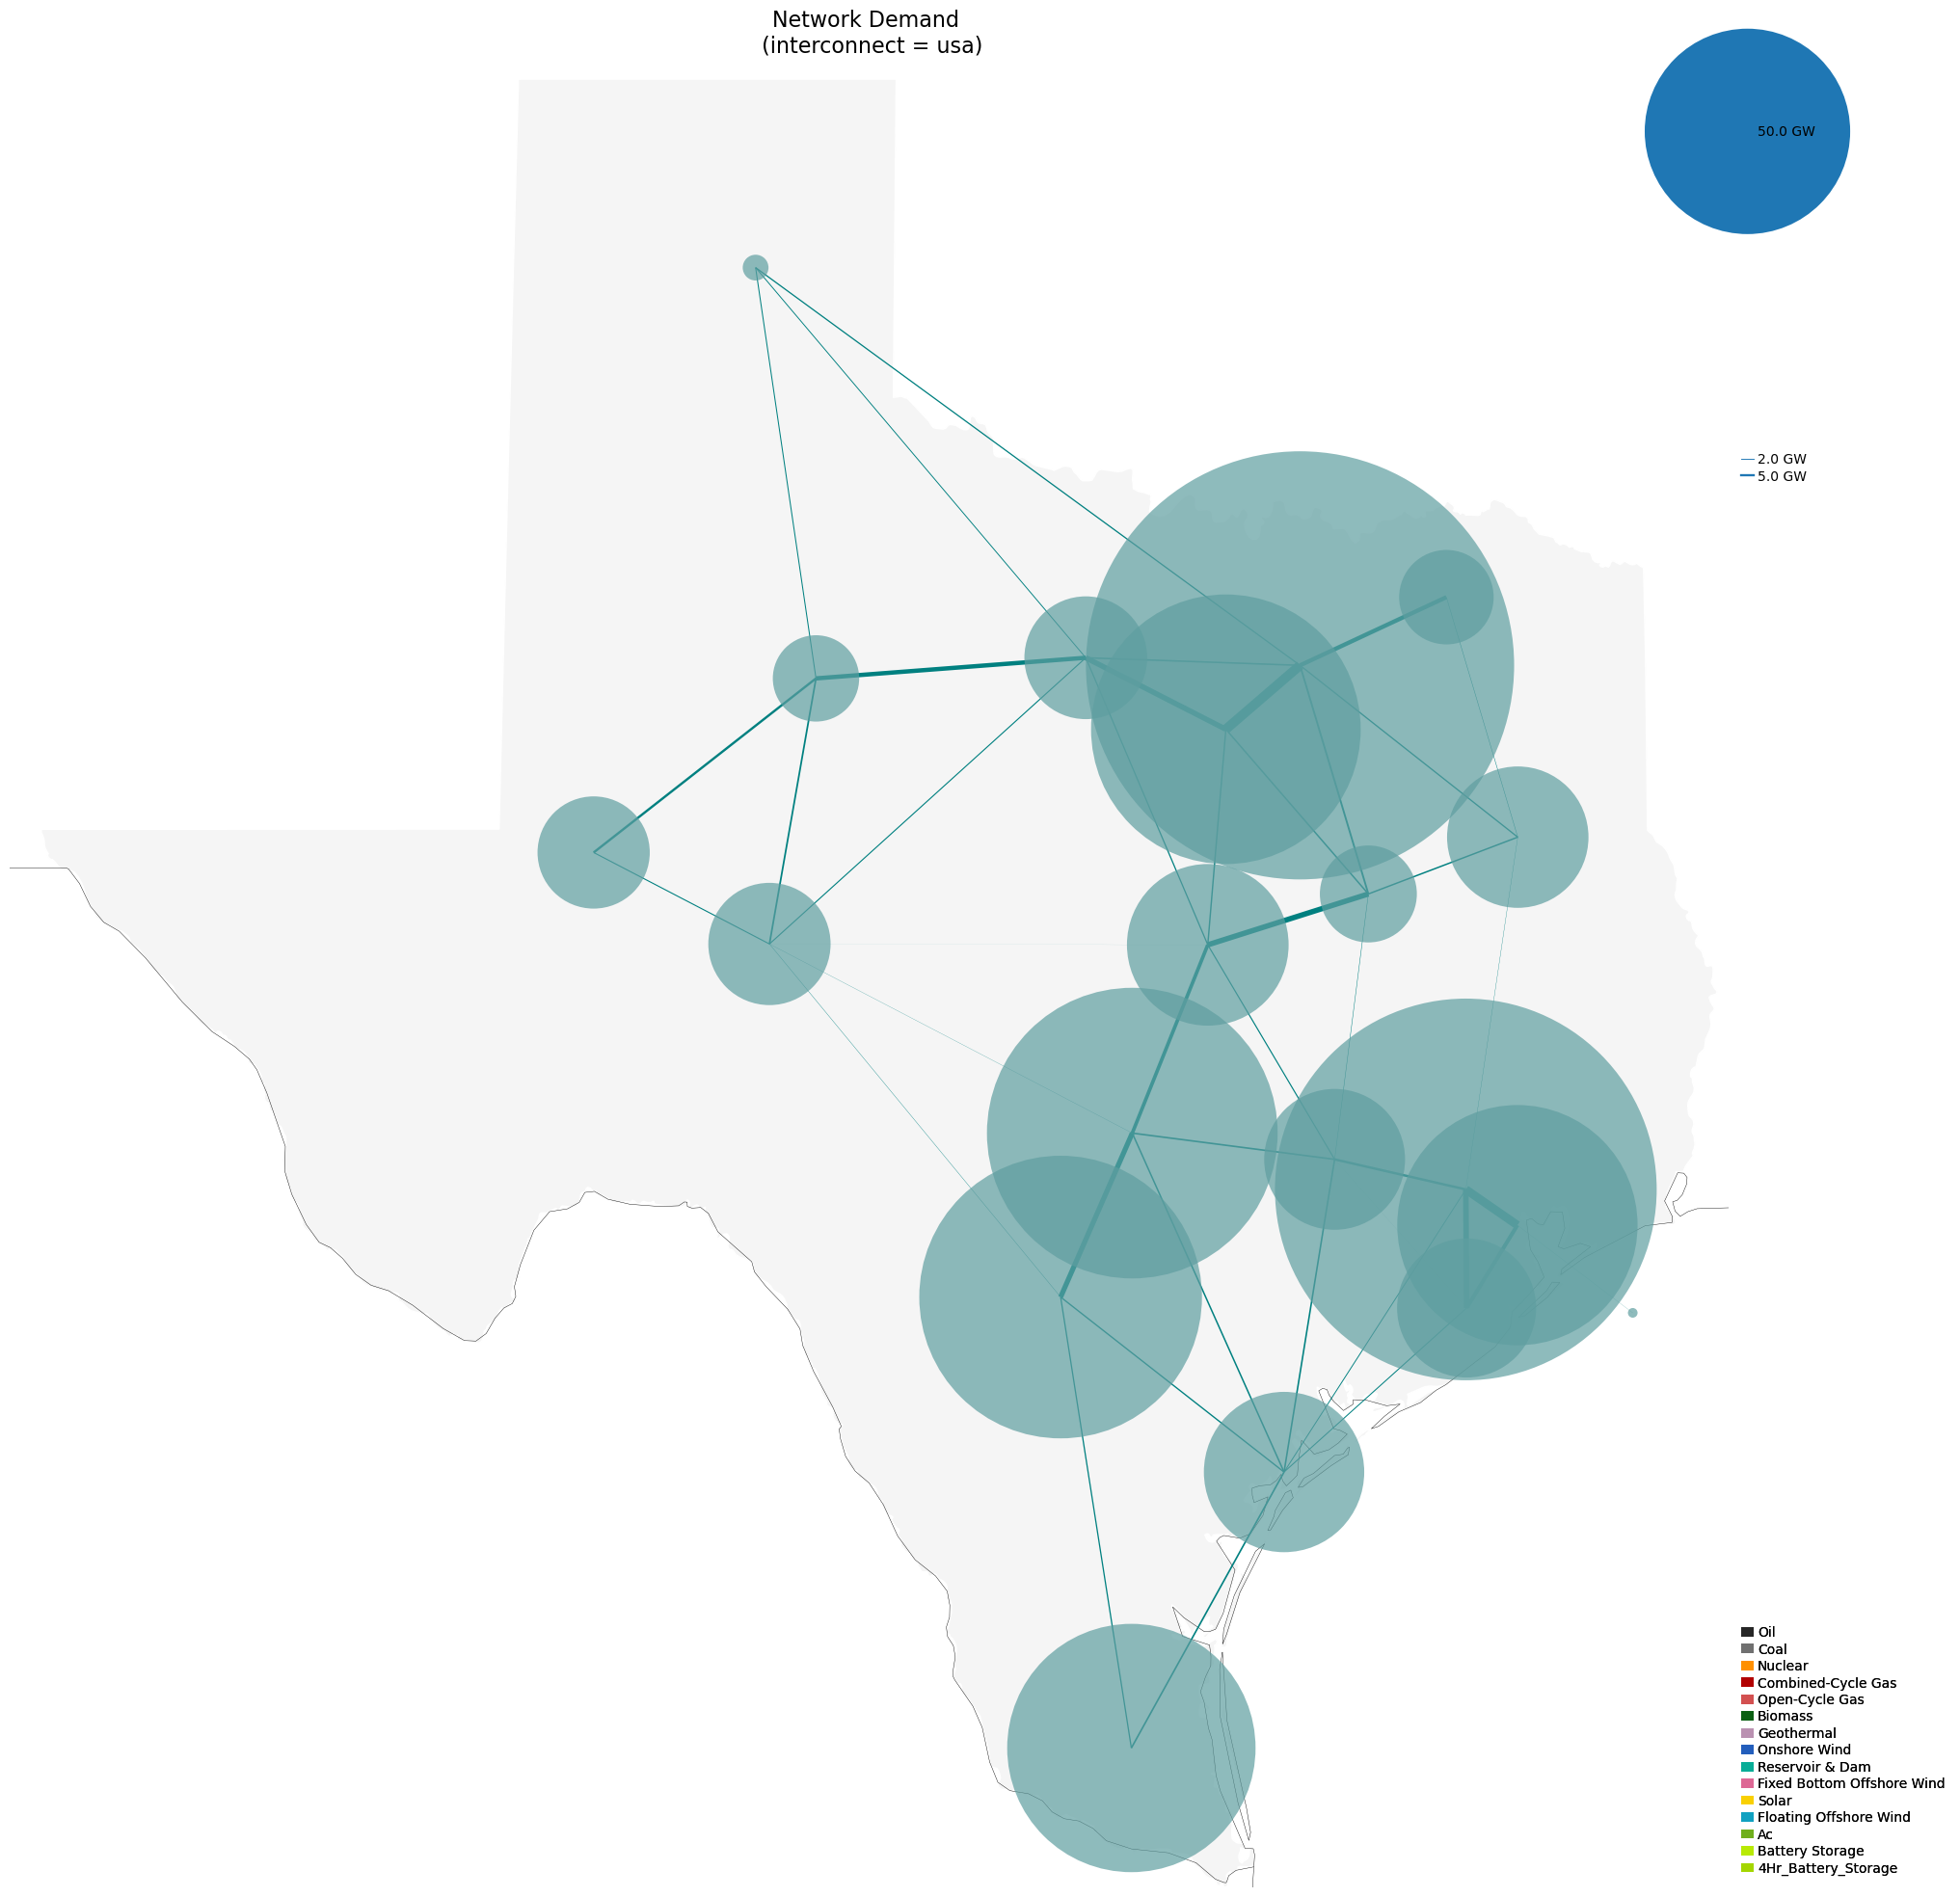

In [345]:
from plot_network_maps import plot_demand_map
import warnings
warnings.filterwarnings("ignore")

# Drop carrier type legend 


# plot demand map
plot_demand_map(
    n=network,
    regions=gdf_states.query("name == 'Texas'"), # for Texas netwroks query to Texas
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_demand_map.png",
    interconnect="usa",
)

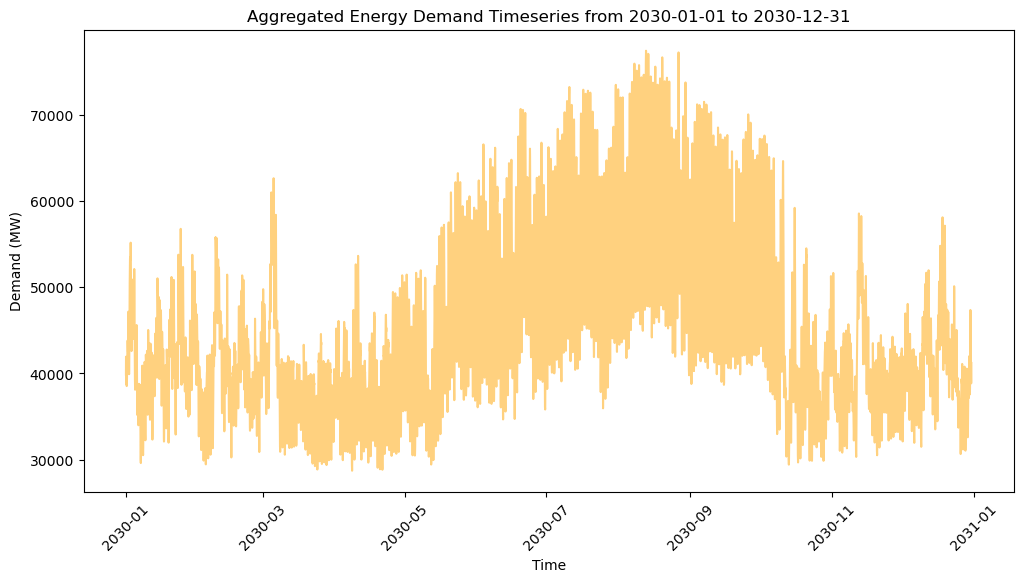

In [348]:
from summary import get_demand_timeseries, get_demand_base

# Get demand timeseries
demand_timeseries = get_demand_timeseries(network)

# Reset index then change timestep column to datetime object
demand_timeseries = demand_timeseries.reset_index()
demand_timeseries["timestep"] = pd.to_datetime(demand_timeseries["timestep"], format="%Y-%m-%d %H:%M:%S")

# Function to plot demand timeseries for a specified window of time. Dont include period in legend
def plot_demand_timeseries(demand_timeseries: pd.DataFrame, start_date: str, end_date: str):
    """
    Plots demand timeseries for a specified window of time.
    """
    # Select data for specified window of time
    data = demand_timeseries[(demand_timeseries["timestep"] >= start_date) & (demand_timeseries["timestep"] <= end_date)]

    # Plot demand
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(data["timestep"], 
    data["Demand"], 
    label="Demand (MWh)", 
    color="orange",
    alpha=0.5)
    ax.set_title(f"Aggregated Energy Demand Timeseries from {start_date} to {end_date}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Demand (MW)")
    plt.xticks(rotation=45)
    plt.show()


# Plot demand timeseries. Change start_date and end_date parameters to desired time period.
plot_demand_timeseries(demand_timeseries, "2030-01-01", "2030-12-31")

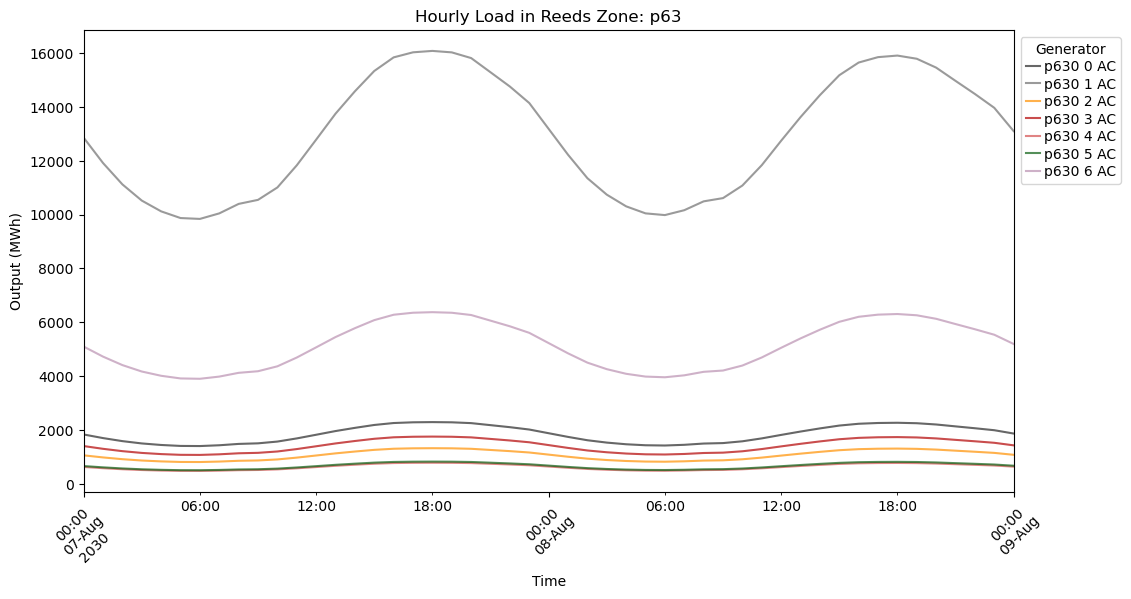

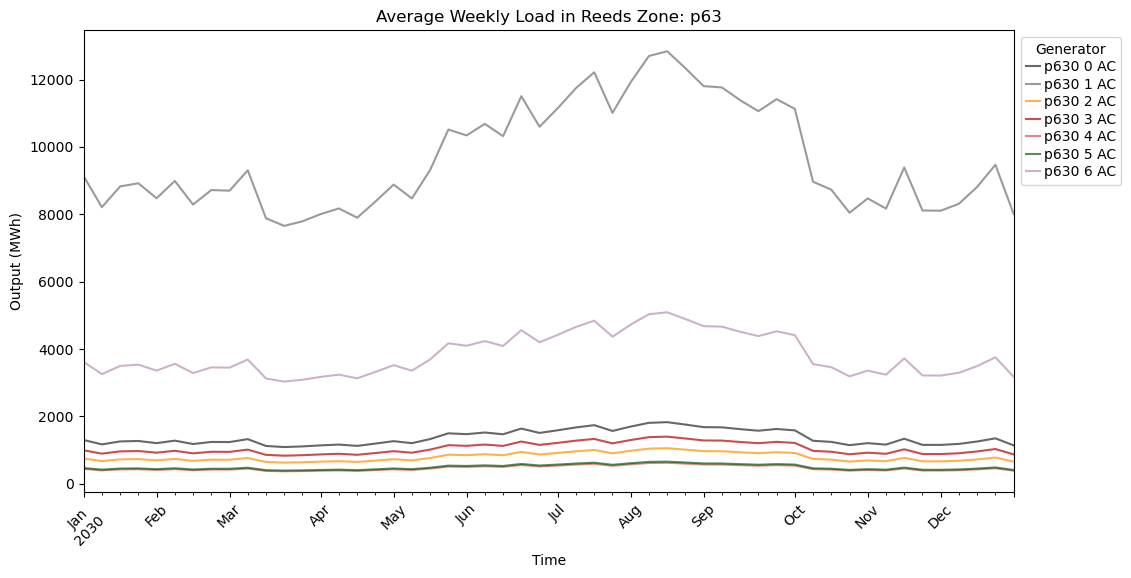

In [371]:
def loads_add_zonal(loads: pd.DataFrame, time_zone: str):
    """
    Network load data as an input and returns a dataframe with load data grouped by geographic features. Default time zone from PYPSA-USA
    is UTC. Convert to desried time zone in the format (US/Time Zone).
    """
    loads_zonal = loads.T

    # Make columns starting at 0 a timestep of data year (currently UTC). 
    loads_zonal.columns = pd.date_range(start="2030-01-01", 
    periods=len(loads_zonal.columns), 
    freq="H",
    tz="UTC")

    # Convert to desired time zone 
    est_time = loads_zonal.columns.tz_convert(time_zone)
    loads_zonal.columns = est_time.tz_localize(None)

    loads_zonal = loads_zonal.reset_index()
    loads_zonal["Bus"] = (loads_zonal["Load"]
    .str.replace('AC', '')
    .str.strip())

    buses_zonal = buses.reset_index()
    buses_zonal["Bus"] = (buses_zonal["Bus"]
    .str.replace('AC', '')
    .str.strip())

    # Set "Bus" as index for both DataFrames
    loads_zonal = loads_zonal.set_index("Bus")
    buses_zonal = buses_zonal.set_index("Bus")

    # Extract "reeds_zone" column from "buses" DataFrame
    reeds_zones = buses[["reeds_zone"]]

    # Join "reeds_zones" with "loads_zonal"
    loads_zonal = loads_zonal.join(reeds_zones, how="left").reset_index()

    loads_zonal["reeds_ba"] = loads_zonal["Bus"].map(buses.reeds_ba)
    loads_zonal["interconnect"] = loads_zonal["Bus"].map(buses.interconnect)
    loads_zonal["reeds_state"] = loads_zonal["Bus"].map(buses.reeds_state)


    loads_zonal = loads_zonal.set_index(["Bus", "reeds_zone", "reeds_ba", 
                                        "interconnect", "reeds_state", "Load"])

    return loads_zonal

#Load_t.p - active power at each bus (positive if neat load)
loads = (loads_add_zonal(network.loads_t.p, "US/Eastern")
        .groupby(["reeds_zone", "Load"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
        .mean()) 


def plot_data(generator:pd.DataFrame, reeds_zone: str, time_zone: str, start_date: str, end_date: str, title: str):
    """
    Plots desired load/generation data for a specified reeds zone, time zone and time period.
    """
    generator.columns = pd.date_range(start="2030-01-01", # update based on start date in data
    periods=len(generator.columns), 
    freq="H",
    tz = "UTC")

    # Convert to desired time zone 
    est_time = generator.columns.tz_convert(time_zone)
    generator.columns = est_time.tz_localize(None)

    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"{title} in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

plot_data(loads, "p63", "US/Eastern", "2030-08-07", "2030-08-09", "Hourly Load")

# Generators_p weekly average 
loads_weekly = loads.resample("W", axis=1).mean()

def plot_data_weekly(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str, title: str):
    """
    Plots desried load/generation weekly average data for a specified reeds zone and time period.
    """
    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"{title} in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

plot_data_weekly(loads_weekly, "p63", "2030-01-01", "2030-12-30", "Average Weekly Load")

### Ouput (Dispatch Scenario)

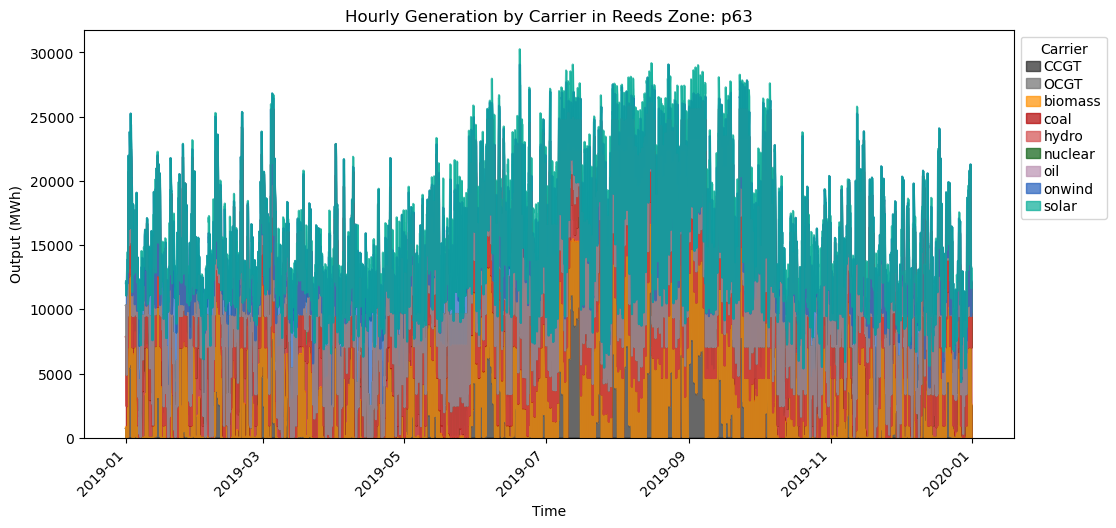

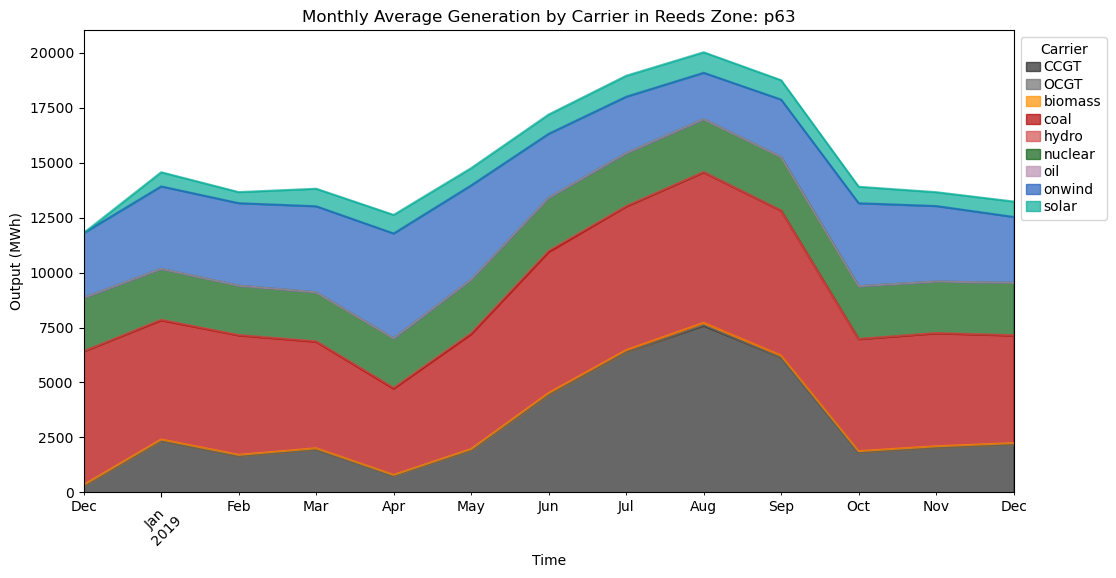

In [360]:
def generator_add_zonal(generator: pd.DataFrame, time_zone: str):
    """
    Takes specific generation data and returns a dataframe with geographic features.
    """
    generator_zonal = generator.T

    # Make columns starting at 0 a timestep of data year (currently UTC). 
    generator_zonal.columns = pd.date_range(start="2019-01-01", 
                                            periods=len(generator_zonal.columns), 
                                            freq="H",
                                            tz="UTC")

    # Convert to desired time zone 
    est_time = generator_zonal.columns.tz_convert(time_zone)
    generator_zonal.columns = est_time.tz_localize(None)

    generator_zonal.index.name = "generator"
    generator_zonal = generator_zonal.reset_index()
 
    generator_zonal["bus"] = generator_zonal["generator"].map(network.generators.bus)
    generator_zonal["reeds_zone"] = generator_zonal["bus"].map(buses.reeds_zone)
    generator_zonal["reeds_ba"] = generator_zonal["bus"].map(buses.reeds_ba)
    generator_zonal["interconnect"] = generator_zonal["bus"].map(buses.interconnect)
    generator_zonal["reeds_state"] = generator_zonal["bus"].map(buses.reeds_state)

    # create column that is generator type from generator 
    generator_zonal["generator_type"] = generator_zonal["generator"].map(network.generators.carrier)

    generator_zonal = generator_zonal.set_index(["bus", "reeds_zone", "reeds_ba", "reeds_state", 
                                    "interconnect", "generator", "generator_type"])

    return generator_zonal

generators_p = (generator_add_zonal(network.generators_t.p, "US/Eastern"))

def plot_generation_by_carrier(generators: pd.DataFrame, reeds_zone: str, title: str):
    """
    Plots area stacked chart of generation by carrier for a given reeds zone.
    """
    # Select data for reeds zone. If intereted in alternate  geographic feature (i.e interconnection), update here by changing selected index.
    data = generators.loc(axis=0)[:, reeds_zone, :, :, :].groupby(["generator_type"]).sum().T

    # Plot data. Use get_color_palette() to get a list of colors for the plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color = carriers.color, alpha=0.7) # fix color to use carrier.color
    ax.set_title(f"{title} Generation by Carrier in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    # Rescale output to 0.0 - 1.0

    plt.show()

# Plot generation by carrier for the specified interconnection
plot_generation_by_carrier(generators_p, "p63", "Hourly")


# Make columns datetime objects and get monthly means
generators_p.columns = pd.to_datetime(generators_p.columns)
generators_p_monthly = generators_p.resample("M", axis=1).mean()

plot_generation_by_carrier(generators_p_monthly, "p63", "Monthly Average")

In [361]:
generators.carrier.unique()

array(['onwind', 'solar', 'CCGT', 'OCGT', 'oil', 'hydro', 'coal',
       'biomass', 'nuclear', 'offwind', 'offwind_floating'], dtype=object)

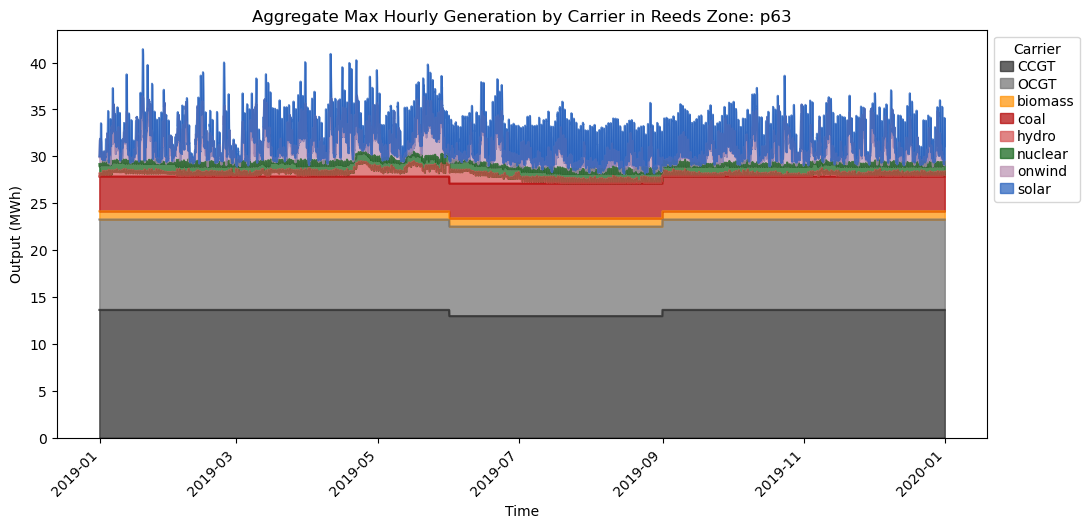

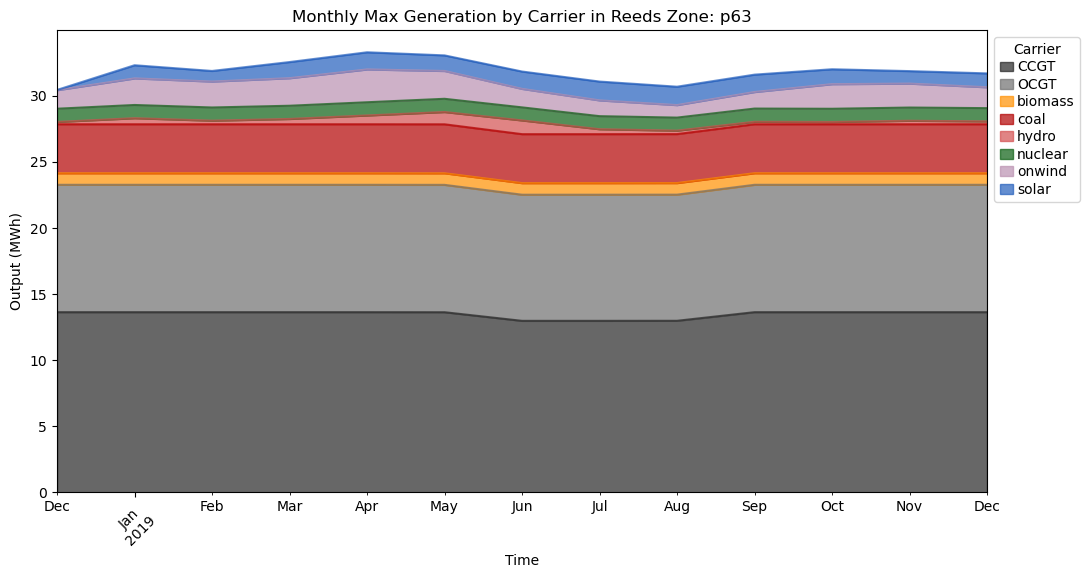

In [363]:
# Import generators-p_max_pu data: The maximum output for each snapshot per unit of p_nom for the optimization 
# (e.g. for variable renewable generators this can change due to weather conditions; for conventional generators it represents a maximum dispatch).
generators_p_max = (generator_add_zonal(network.generators_t.p_max_pu, "US/Eastern")).reset_index()

# Create column that is generator type from generator 
generators_p_max["generator_type"] = generators_p_max["generator"].map(network.generators.carrier)
generators_p_max = generators_p_max.set_index(["bus", "reeds_zone", "reeds_ba", "reeds_state", 
                                    "interconnect", "generator", "generator_type"])

# Plot generation by carrier for the specified interconnection
plot_generation_by_carrier(generators_p_max, "p63", "Aggregate Max Hourly")


# Make columns datetime objects and get monthly means
generators_p_max.columns = pd.to_datetime(generators_p_max.columns)
generators_p_max_monthly = generators_p_max.resample("M", axis=1).mean()

plot_generation_by_carrier(generators_p_max_monthly, "p63", "Monthly Max")


### Marginal Cost Statistics

look into regional costs and how they are incorporated into mc calculations 

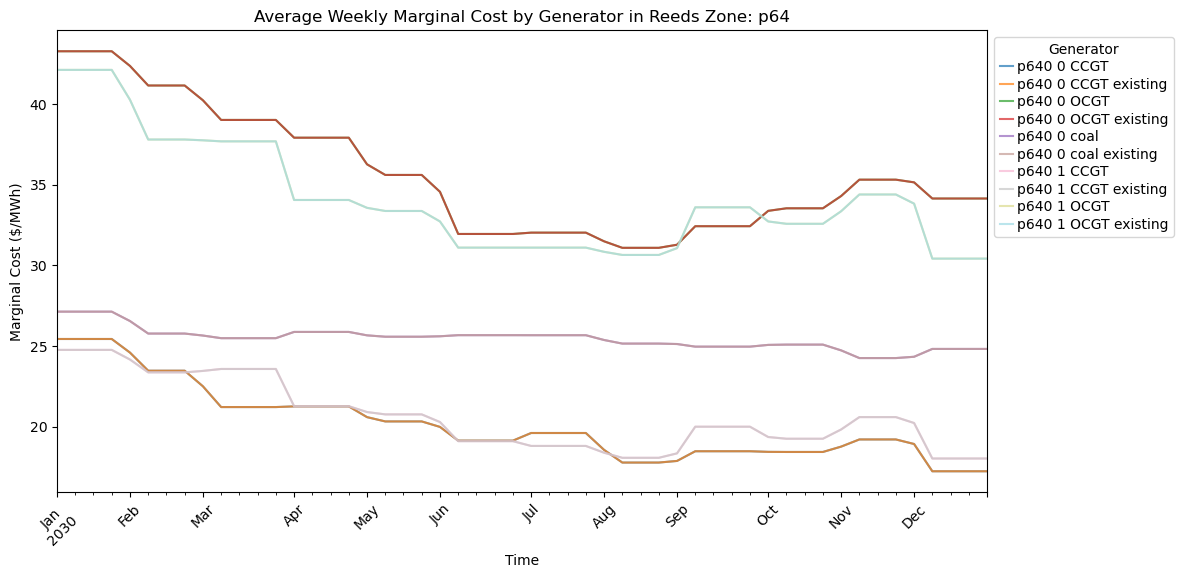

In [366]:
# Import generators_t_marginal_cost data: Marginal cost of production of 1 MWh.
generators_mc = (generator_add_zonal(network.generators_t.marginal_cost, "US/Eastern")
                .groupby(["reeds_zone", "generator"]) # Change groupby to desired setting (i.e reeds_state). Will require plot functions to be updated accordingly.
                .sum())

def plot_generators_mc_weekly(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots average weekly marginal cost by generator for a specified reeds zone and time period.
    """
    generator.columns = pd.date_range(start="2030-01-01", 
    periods=len(generator.columns), 
    freq="H")

    generators_weekly = (generator
                        .resample("W", axis=1)
                        .mean())

    # Select data for reeds zone
    data = generators_weekly.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Average Weekly Marginal Cost by Generator in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Marginal Cost ($/MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()


# Plot marginal cost by generator for specified reeds_zone and time period
plot_generators_mc_weekly(generators_mc, 'p64', "2030-01-01", "2030-12-30")

In [339]:
generators_p.head()

2018-12-31 19:00:00  \
bus     reeds_zone reeds_ba reeds_state interconnect generator       generator_type                        
p1000 0 p100       PJM      VA          Eastern      p1000 0 OCGT    OCGT                       0.001937   
                                                     p1000 0 biomass biomass                    1.998065   
                                                     p1000 0 hydro   hydro                      1.148967   
                                                     p1000 0 load    load                       0.040632   
                                                     p1000 0 onwind  onwind                     0.000000   

                                                                                     2018-12-31 20:00:00  \
bus     reeds_zone reeds_ba reeds_state interconnect generator       generator_type                        
p1000 0 p100       PJM      VA          Eastern      p1000 0 OCGT    OCGT                       0.001937   
                                                     p1000 0 biomass biomass                    1.998066   
                                                     p1000 0 hydro   hydro                      0.946947   
                                                     p1000 0 load    load                       0.040681   
                                                     p1000 0 onwind  onwind                     0.000000   

                                                                                     2018-12-31 21:00:00  \
bus     reeds_zone reeds_ba reeds_state interconnect generator       generator_type                        
p1000 0 p100       PJM      VA          Eastern      p1000 0 OCGT    OCGT                       0.001939   
                                                     p1000 0 biomass biomass                    1.998068   
                                                     p1000 0 hydro   hydro                      0.662965   
                                                     p1000 0 load    load                       0.040621   
                                                     p1000 0 onwind  onwind                     0.000000   

                                                                                     2018-12-31 22:00:00  \
bus     reeds_zone reeds_ba reeds_state interconnect generator       generator_type                        
p1000 0 p100       PJM      VA          Eastern      p1000 0 OCGT    OCGT                       0.001938   
                                                     p1000 0 biomass biomass                    1.998069   
                                                     p1000 0 hydro   hydro                      0.433555   
                                                     p1000 0 load    load                       0.040781   
                                                     p1000 0 onwind  onwind                     0.000000   

                                                                                     2018-12-31 23:00:00  \
bus     reeds_zone reeds_ba reeds_state interconnect generator       generator_type                        
p1000 0 p100       PJM      VA          Eastern      p1000 0 OCGT    OCGT                       0.001939   
                                                     p1000 0 biomass biomass                    1.998071   
                                                     p1000 0 hydro   hydro                      0.430770   
                                                     p1000 0 load    load                       0.040719   
                                                     p1000 0 onwind  onwind                     0.000000   

                                                                                     2019-01-01 00:00:00  \
bus     reeds_zone reeds_ba reeds_state interconnect generator       generator_type                        
p1000 0 p100       PJM      VA          Eastern      p1000 0 OCGT    OCGT           

In [338]:
generators_mc.head()

2019-01-01 00:00:00  2019-01-01 01:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              41.390793            41.390793   
           p11 0 OCGT              49.931988            49.931988   
p10        p101 0 CCGT             47.679344            47.679344   
           p101 0 OCGT             68.327827            68.327827   
p100       p1000 0 OCGT            53.220734            53.220734   

                         2019-01-01 02:00:00  2019-01-01 03:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              41.390793            41.390793   
           p11 0 OCGT              49.931988            49.931988   
p10        p101 0 CCGT             47.679344            47.679344   
           p101 0 OCGT             68.327827            68.327827   
p100       p1000 0 OCGT            53.220734            53.220734   

                         2019-01-01 04:00:00  2019-01-01 05:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              41.390793            41.390793   
           p11 0 OCGT              49.931988            49.931988   
p10        p101 0 CCGT             47.679344            47.679344   
           p101 0 OCGT             68.327827            68.327827   
p100       p1000 0 OCGT            53.220734            53.220734   

                         2019-01-01 06:00:00  2019-01-01 07:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              41.390793            41.390793   
           p11 0 OCGT              49.931988            49.931988   
p10        p101 0 CCGT             47.679344            47.679344   
           p101 0 OCGT             68.327827            68.327827   
p100       p1000 0 OCGT            53.220734            53.220734   

                         2019-01-01 08:00:00  2019-01-01 09:00:00  ...  \
reeds_zone generator                                               ...   
p1         p11 0 CCGT              41.390793            41.390793  ...   
           p11 0 OCGT              49.931988            49.931988  ...   
p10        p101 0 CCGT             47.679344            47.679344  ...   
           p101 0 OCGT             68.327827            68.327827  ...   
p100       p1000 0 OCGT            53.220734            53.220734  ...   

                         2019-12-31 14:00:00  2019-12-31 15:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              32.447067            32.447067   
           p11 0 OCGT              39.975952            39.975952   
p10        p101 0 CCGT             45.416206            45.416206   
           p101 0 OCGT             65.244980            65.244980   
p100       p1000 0 OCGT            47.822956            47.822956   

                         2019-12-31 16:00:00  2019-12-31 17:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              32.447067            32.447067   
           p11 0 OCGT              39.975952            39.975952   
p10        p101 0 CCGT             45.416206            45.416206   
           p101 0 OCGT             65.244980            65.244980   
p100       p1000 0 OCGT            47.822956            47.822956   

                         2019-12-31 18:00:00  2019-12-31 19:00:00  \
reeds_zone generator                                                
p1         p11 0 CCGT              32.447067            32.447067   
           p11 0 OCGT              39.975952            39.975952   
p10        p101 0 CCGT             45.416206            45.416206   
           p101 0 OCGT             65.244980            65.244980   
p100       p1000 0 OCGT            47.822956            47.822956   

                         2019-12-31 20:00:00  2019-12-31 21:00:00  \
reeds_zone generator                             

In [129]:
from summary import get_fuel_costs

# approximates for 2030
fixed_voms = {
        "coal": 8.18,
        "oil": 6.42,
        "CCGT": 1.84,
        "OCGT": 6.44,
        "nuclear": 2.47,
    }


marginal_costs = network.get_switchable_as_dense("Generator", "marginal_cost").T
marginal_costs = marginal_costs[
        marginal_costs.index.map(network.generators.carrier).isin(list(fixed_voms))
    ]

voms = pd.Series(
        index=marginal_costs.index,
        data=marginal_costs.index.map(network.generators.carrier).map(fixed_voms).fillna(0),
    ).astype(float)

marginal_costs = marginal_costs.subtract(voms, axis=0)

# remove the efficiency cost
eff = network.get_switchable_as_dense("Generator", "efficiency").T
eff = eff[eff.index.map(network.generators.carrier).isin(list(fixed_voms))]
fuel_costs = marginal_costs.mul(eff, axis=0)

    # add indices for bus and carrier
fuel_costs = fuel_costs.reset_index()
fuel_costs["bus"] = fuel_costs.Generator.map(network.generators.bus)
fuel_costs["carrier"] = fuel_costs.Generator.map(network.generators.carrier)
fuel_costs = fuel_costs.groupby(["carrier", "bus", "Generator"]).sum().T

fuel_costs.index = pd.to_datetime(fuel_costs.index)
fuel_costs.T


TypeError: the first argument must be callable

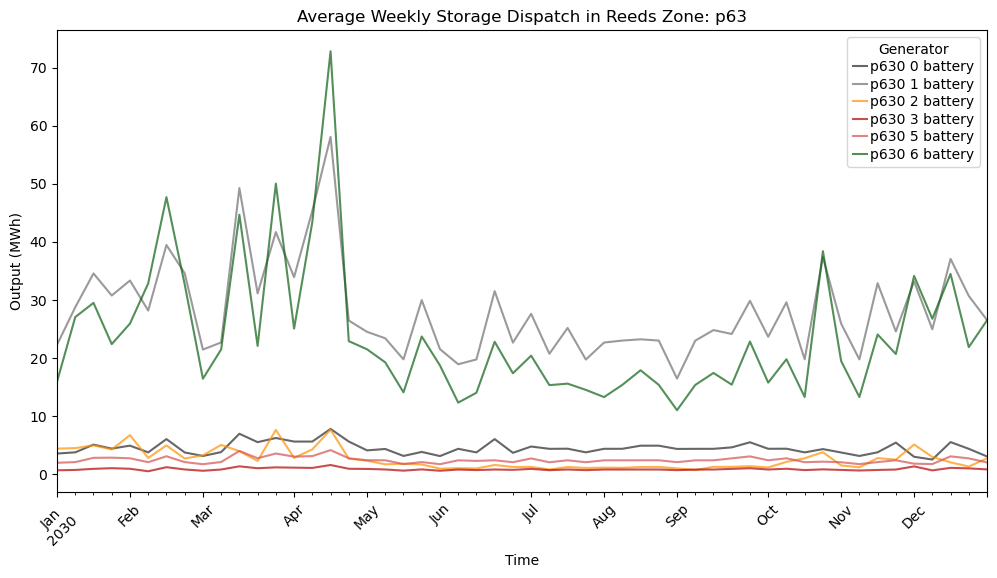

In [372]:
def storage_add_zonal(storage: pd.DataFrame, time_zone: str):
    """
    Network storage data as an input and returns a dataframe with storage data grouped by geographic features. Default time zone from PYPSA-USA
    is UTC. Convert to desried time zone in the format (US/Time Zone).
    """
    storage_zonal = storage.T

    # Make columns starting at 0 a timestep of data (currently UTC)
    storage_zonal.columns = pd.date_range(start="2030-01-01", 
    periods=len(storage_zonal.columns), 
    freq="H",
    tz="UTC")

    # Convert to desired time zone 
    est_time = storage_zonal.columns.tz_convert(time_zone)
    storage_zonal.columns = est_time.tz_localize(None)

    storage_zonal = storage_zonal.reset_index()
    storage_zonal["Bus"] = (storage_zonal["StorageUnit"]
    .str.replace('battery', '')
    .str.strip())

    buses_zonal = buses.reset_index()
    buses_zonal["Bus"] = (buses_zonal["Bus"]
    .str.replace('battery', '')
    .str.strip())

    # Set "Bus" as index for both DataFrames
    storage_zonal = storage_zonal.set_index("Bus")
    buses_zonal = buses_zonal.set_index("Bus")

    # Extract "reeds_zone" column from "buses" DataFrame
    reeds_zones = buses[["reeds_zone"]]

    # Join "reeds_zones" with "loads_zonal"
    storage_zonal = storage_zonal.join(reeds_zones, how="left").reset_index()

    storage_zonal["reeds_ba"] = storage_zonal["Bus"].map(buses.reeds_ba)
    storage_zonal["interconnect"] = storage_zonal["Bus"].map(buses.interconnect)
    storage_zonal["reeds_state"] = storage_zonal["Bus"].map(buses.reeds_state)

    storage_zonal = storage_zonal.set_index(["Bus", "reeds_zone", "reeds_ba", 
                                        "interconnect", "reeds_state", "StorageUnit"])

    return storage_zonal


#storage_units_t.p_dispatch - active power dispatch at bus
storage_dispatch = (storage_add_zonal(network.storage_units_t.p_dispatch, "US/Eastern")
                    .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                    .mean()) 

storage_dispatch.columns = pd.to_datetime(storage_dispatch.columns)
storage_dispatch_weekly = storage_dispatch.resample("W", axis=1).mean()

plot_data_weekly(storage_dispatch_weekly, "p63", "2030-01-01", "2030-12-30", "Average Weekly Storage Dispatch")

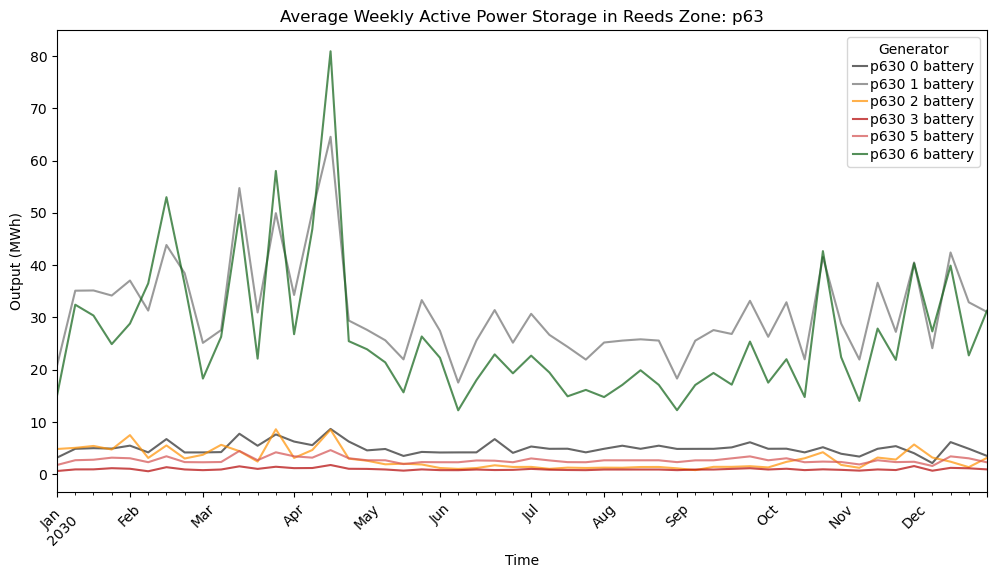

In [375]:
# Import storage_units_p_store - active power charging at bus 
storage_store = (storage_add_zonal(network.storage_units_t.p_store, "US/Eastern")
                .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                .mean()) 

storage_store.columns = pd.to_datetime(storage_store.columns)
storage_store_weekly = storage_store.resample("W", axis=1).mean()

plot_data_weekly(storage_store_weekly, "p63", "2030-01-01", "2030-12-30", "Average Weekly Active Power Storage")

In [377]:
# pull p127 from storage store
storage_dispatch_weekly.loc(axis=0)["p63"].T.head()

StorageUnit,p630 0 battery,p630 1 battery,p630 2 battery,p630 3 battery,p630 5 battery,p630 6 battery
2030-01-06,3.554394,22.284135,4.405100,0.673885,1.966523,15.935782
2030-01-13,3.765790,28.751777,4.487500,0.733849,2.084182,27.058797
2030-01-20,5.092470,34.565857,4.970533,0.924753,2.819274,29.499169
2030-01-27,4.408873,30.765874,4.253399,1.036299,2.846813,22.395421
2030-02-03,4.916655,33.347043,6.726821,0.936960,2.743703,25.933876


In [376]:
storage_store_weekly.loc(axis=0)["p63"].T.head()

StorageUnit,p630 0 battery,p630 1 battery,p630 2 battery,p630 3 battery,p630 5 battery,p630 6 battery
2030-01-06,3.174352,20.752184,4.823055,0.612288,1.764938,15.034659
2030-01-13,4.860288,35.110384,5.044226,0.915637,2.675670,32.426014
2030-01-20,4.980102,35.153021,5.404998,0.924815,2.769979,30.352412
2030-01-27,4.898340,34.183428,4.724976,1.150840,3.162714,24.882984
2030-02-03,5.463589,37.053430,7.476999,1.041838,3.049302,28.816437


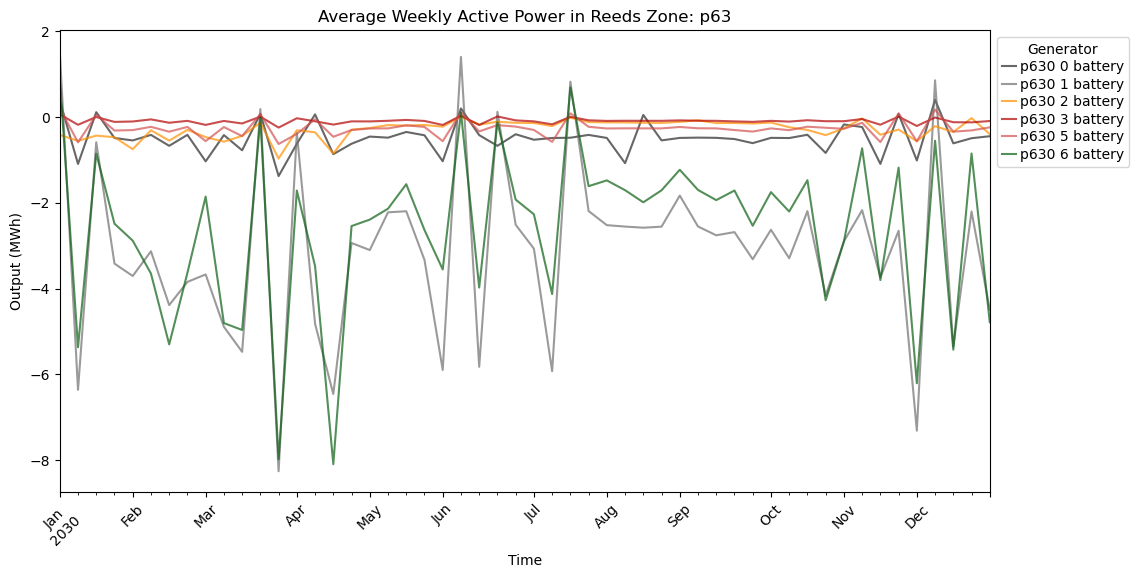

In [378]:
# Import storage_units_t - active power at bus (positive if net generation)
storage_p = (storage_add_zonal(network.storage_units_t.p, "US/Eastern")
            .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
            .mean()) 

storage_p.columns = pd.to_datetime(storage_p.columns)
storage_p_weekly = storage_p.resample("W", axis=1).mean()

plot_data_weekly(storage_p_weekly, "p63","2030-01-01", "2030-12-31", "Average Weekly Active Power")

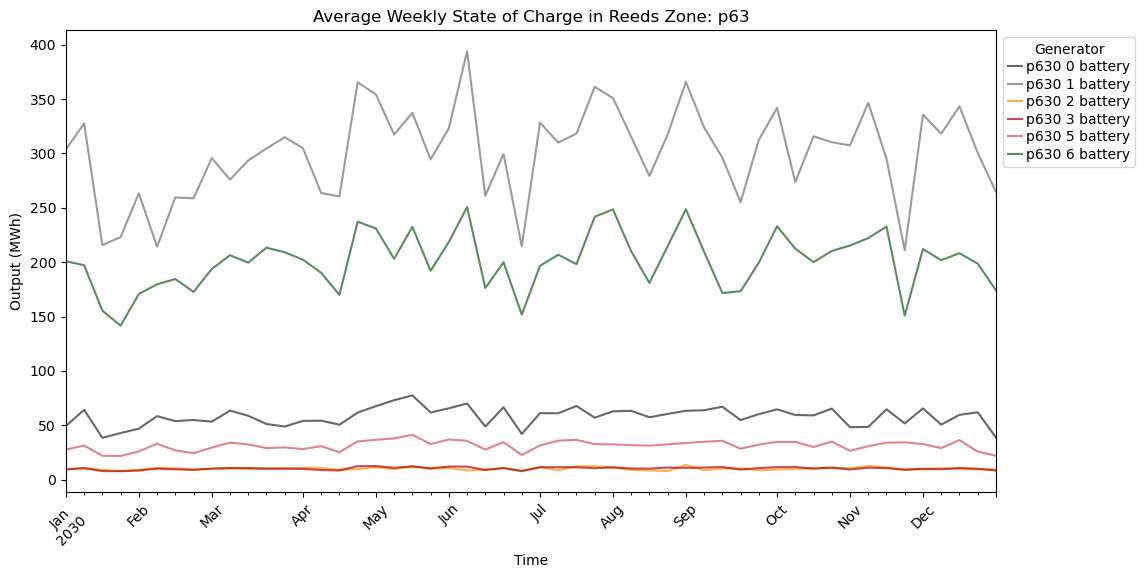

In [379]:
# Import storage_units_t_state_of_charge - state of charge as calculated by the OPF.
storage_state_charge = (storage_add_zonal(network.storage_units_t.state_of_charge, "US/Eastern")
                        .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                        .mean()) 


storage_state_charge.columns = pd.to_datetime(storage_state_charge.columns)
storage_state_weekly = storage_state_charge.resample("W", axis=1).mean()

plot_data_weekly(storage_state_weekly, "p63", "2030-01-01", "2030-12-30", "Average Weekly State of Charge")


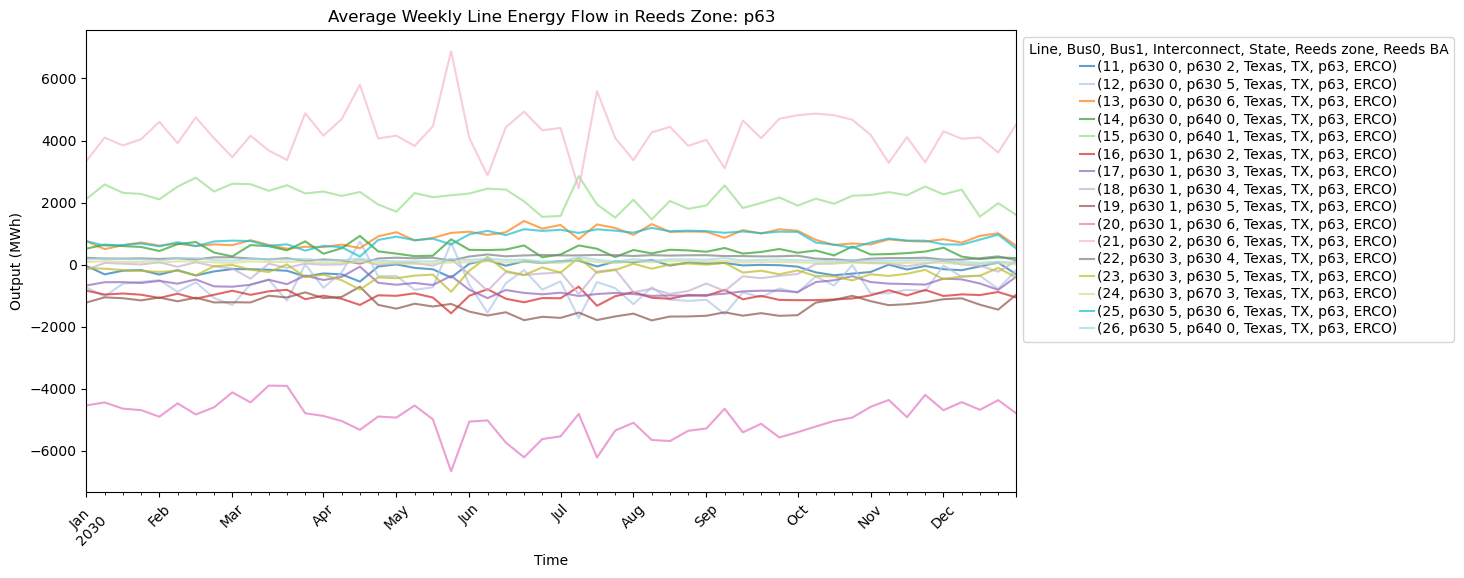

In [381]:
def lines_add_zonal(line: pd.DataFrame, time_zone: str):
    """
    Line_p0 or line_p1 pandas dataframe as an input and returns a dataframe with line active power flow with geographic features. Default time zone from PYPSA-USA
    is UTC. Convert to desried time zone in the format (US/Time Zone).

    Line_p0 - Active power at bus0

    line_p1 - Active power at bus1
    """                                                                                                                                                                                                           
    line_zonal = line.T.reset_index()

    line_zonal.columns = line_zonal.columns.droplevel(1)

    lines_select = (network.lines[["bus0", "bus1", "interconnect"]]
                    .reset_index())

    line_zonal = (line_zonal.merge(lines_select, on="Line")
                            .set_index(["Line", "bus0", "bus1", "interconnect"]))
              
    # Make columns starting at 0 a timestep of first day of data year (currently UTC).
    line_zonal.columns = pd.date_range(start="2030-01-01", 
    periods=len(line_zonal.columns), 
    freq="H",
    tz="UTC")

    # Convert to desired time zone 
    est_time = line_zonal.columns.tz_convert(time_zone)
    line_zonal.columns = est_time.tz_localize(None)


    # Extract "reeds_zone" column from "buses" DataFrame
    reeds_zones = (buses[["reeds_zone"]].reset_index()
                    .rename(columns={"Bus": "bus0"})) # change rename based on input data (i.e using lines_p0 use bus0)

    # Map reeds zone
    line_zonal = line_zonal.reset_index()
    line_zonal = line_zonal.merge(reeds_zones, on="bus0")


    line_zonal["reeds_ba"] = line_zonal["bus0"].map(buses.reeds_ba)
    line_zonal["reeds_state"] = line_zonal["bus0"].map(buses.reeds_state)

    line_zonal = line_zonal.set_index(["Line", "bus0", "bus1", 
                                        "interconnect", "reeds_state", "reeds_zone", "reeds_ba"])

    return line_zonal

lines0_zonal = lines_add_zonal(network.lines_t.p0, "US/Eastern")

# Weekly mean of line energy flow 
lines0_zonal.columns = pd.to_datetime(lines0_zonal.columns)
lines0_weekly = lines0_zonal.resample("W", axis=1).mean()

# function to plot lines0_weekly for specified reeds_zone. Plots all the lines in the zone. 
def plot_lines_weekly(lines: pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots average weekly line energy flow for a specified reeds zone and time period.
    """
    # Select data for reeds zone
    data = lines.loc(axis=0)[:, :, :, :, :, reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Average Weekly Line Energy Flow in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Line, Bus0, Bus1, Interconnect, State, Reeds zone, Reeds BA", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

plot_lines_weekly(lines0_weekly, "p63", "2030-01-01", "2030-12-30")